In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.constants import c as clight
from astropy.constants import e as e_elec
from astropy.constants import h as hplanck
from astropy.cosmology import WMAP9 as cosmo
import glob
import h5py
import yt

$$\tau_{\rm eff, LL} (r,\nu) = \int_0^r \kappa_{\rm LL} (r',\nu) d r'$$

In [2]:
clight_kmps=clight.to("km/s").value

In [58]:
vout

array([    0.        ,   303.03030303,   606.06060606,   909.09090909,
        1212.12121212,  1515.15151515,  1818.18181818,  2121.21212121,
        2424.24242424,  2727.27272727,  3030.3030303 ,  3333.33333333,
        3636.36363636,  3939.39393939,  4242.42424242,  4545.45454545,
        4848.48484848,  5151.51515152,  5454.54545455,  5757.57575758,
        6060.60606061,  6363.63636364,  6666.66666667,  6969.6969697 ,
        7272.72727273,  7575.75757576,  7878.78787879,  8181.81818182,
        8484.84848485,  8787.87878788,  9090.90909091,  9393.93939394,
        9696.96969697, 10000.        , 10303.03030303, 10606.06060606,
       10909.09090909, 11212.12121212, 11515.15151515, 11818.18181818,
       12121.21212121, 12424.24242424, 12727.27272727, 13030.3030303 ,
       13333.33333333, 13636.36363636, 13939.39393939, 14242.42424242,
       14545.45454545, 14848.48484848, 15151.51515152, 15454.54545455,
       15757.57575758, 16060.60606061, 16363.63636364, 16666.66666667,
      

In [3]:
clight_kmps

299792.458

In [2]:
def drdz(z):
    return clight/cosmo.H(z)/(1+z)

def drdz_matter_dom(z):
    return clight/cosmo.H0/cosmo.Om0**0.5*(1+z)**(-2.5)

In [3]:
#(hplanck*clight/astropy.units.quantity.Quantity(1,"eV")).to("AA")
eV2lambdaAA=lambda eV:12398.42/eV
lambdaAA2eV=lambda AA:12398.42/AA

In [4]:
def sigma_HI_nu(nu):
    nuHI=13.6
    sigma_HI=6.30e-18*(1.34*(nu/nuHI)**-2.99-0.34*(nu/nuHI)**-3.99) #cm**2
    sigma_HI[nu<nuHI]=0
    return sigma_HI

Text(0, 0.5, 'cm^2')

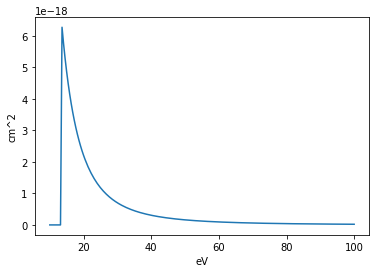

In [7]:
test_eV_array=np.linspace(10.,100,200)
test_AA_array=eV2lambdaAA(test_eV_array)
plt.plot(test_eV_array,sigma_HI_nu(test_eV_array))
plt.xlabel("eV")
plt.ylabel("cm^2")

$$ d \tau = n \sigma dr $$

In [5]:
def calc_tau(nHI,dr_pMpc,eVarray):
    dr=dr_pMpc*3.08e24 #cm
    return nHI*dr*sigma_HI_nu(eVarray) #

In [6]:
def tau_profile(vspec_out,nHI,dr_pMpc):
    lambdaAA_out=eV2lambdaAA(13.6)*(1-vspec_out/2.9979246e5)
    eV_out=lambdaAA2eV(lambdaAA_out)
    return calc_tau(nHI,dr_pMpc,eV_out)

In [7]:
def tau_per_denpixel(vspec_out,pos_pMpc,nHI,vlos,dr_pMpc,Hz):
    vel_space_pos=pos_pMpc*Hz-vlos
    v_relative=vspec_out-vel_space_pos
    lambdaAA_out=eV2lambdaAA(13.6)*(1-v_relative/2.9979246e5)
    eV_out=lambdaAA2eV(lambdaAA_out)
    return calc_tau(nHI,dr_pMpc,eV_out)

In [9]:
# observers usually use range 820~912 AA
(912-820)/912*clight.to("km/s")

<Quantity 30242.22164035 km / s>

### a fake uniform sightline as a test

In [10]:
dr_pMpc=0.01
Ncell=500
print("total integration length= {:f} pMpc".format(dr_pMpc*Ncell))
dr_pMpc_array=np.ones(Ncell)*dr_pMpc
pos_arr_pMpc=np.cumsum(dr_pMpc_array)
nHI_arr=np.ones(Ncell)*1e-8
vlos_arr=np.zeros(Ncell)

total integration length= 5.000000 pMpc


In [8]:
def integ_tau(vspec_out,pos_arr_pMpc,nHI,vlos,dr_pMpc,Hz):
    tau_matrix=np.array([tau_per_denpixel(vspec_out,pos_arr_pMpc[i],\
                       nHI[i],vlos[i],dr_pMpc[i],Hz) for i in range(len(pos_arr_pMpc))])
    return np.sum(tau_matrix,axis=0)

In [59]:
vout=np.linspace(0,30000,1000)
AAout=eV2lambdaAA(13.6)*(1-vout/2.9979246e5)

In [60]:
plt.plot(AAout,integ_tau(vout,pos_arr_pMpc,nHI_arr,vlos_arr,dr_pMpc_array,600))


NameError: name 'pos_arr_pMpc' is not defined

Text(0, 0.5, 'transmitted flux')

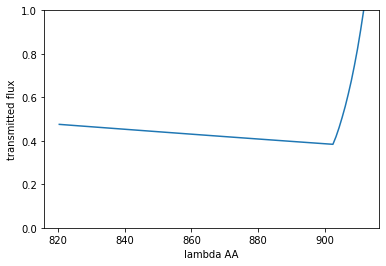

In [14]:
plt.plot(AAout,np.exp(-integ_tau(vout,pos_arr_pMpc,nHI_arr,vlos_arr,dr_pMpc_array,600)))
plt.ylim(0,1)
plt.xlabel("lambda AA")
plt.ylabel("transmitted flux")

In [18]:
sigmaHI=6.3e-18

In [10]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1401_50pMpc/"
zuni=1/0.1401-1
Hz=cosmo.H(zuni).value
print(zuni)

6.137758743754461


In [38]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=24
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

In [65]:
losName

'/data/hqchen/mfp_project/data/F_a0.1401_50pMpc/lightray_h6327262_n40.h5'

yt : [INFO     ] 2024-03-12 14:24:27,948 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:27,949 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:27,950 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:27,951 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:27,953 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:27,953 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:27,954 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:27,955 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:27,956 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:27,957 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[  0.99951404   0.99921651   0.99904627 ... 292.76999358 292.77286397
 292.77352074]
1.5626272559899543
15.860388460354079


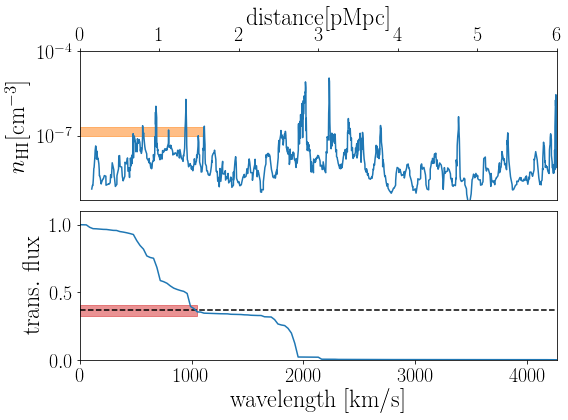

yt : [INFO     ] 2024-03-12 14:24:30,190 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:30,191 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:30,192 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:30,193 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:30,194 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:30,195 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:30,196 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:30,197 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:30,198 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:30,199 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[ 0.99104551  0.99010676  0.98435446 ... 33.71452831 33.71498599
 33.71499412]
2.5006733511684263
15.420962809005603


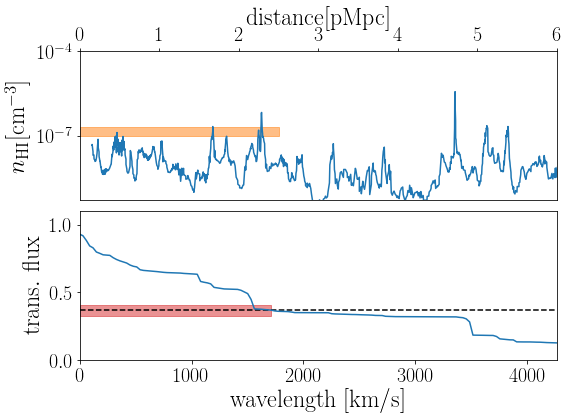

yt : [INFO     ] 2024-03-12 14:24:32,016 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:32,017 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:32,018 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:32,019 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:32,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:32,021 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:32,021 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:32,022 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:32,023 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:32,024 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[ 0.99963672  0.99705733  0.99506759 ... 94.73640033 94.73650986
 94.73657734]
1.452853736496898
17.99113689866689


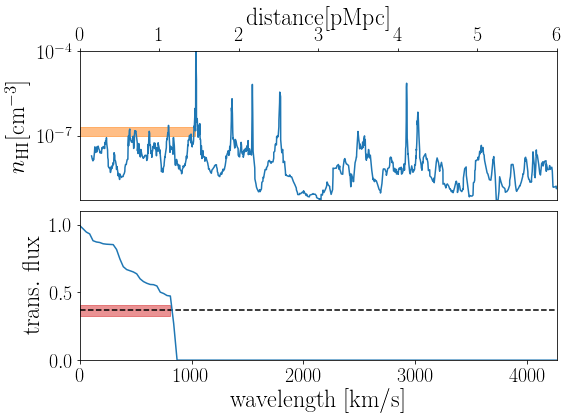

yt : [INFO     ] 2024-03-12 14:24:34,015 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:34,016 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:34,017 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:34,018 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:34,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:34,020 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:34,020 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:34,021 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:34,022 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:34,023 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.98521951e-01 9.96989933e-01 9.94529870e-01 ... 2.55962541e+03
 2.55962763e+03 2.55963104e+03]
3.351924338254211
15.960861656994062


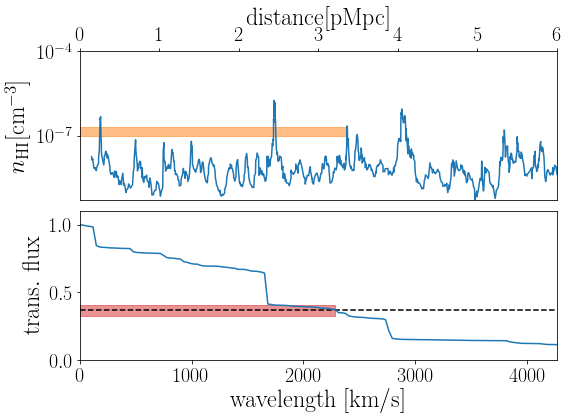

yt : [INFO     ] 2024-03-12 14:24:35,865 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:35,866 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:35,867 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:35,868 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:35,869 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:35,870 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:35,871 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:35,871 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:35,872 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:35,873 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[ 0.9979146   0.99677262  0.99665188 ... 57.68487982 57.68496901
 57.68515349]
1.7413282946957396
16.361355569662116


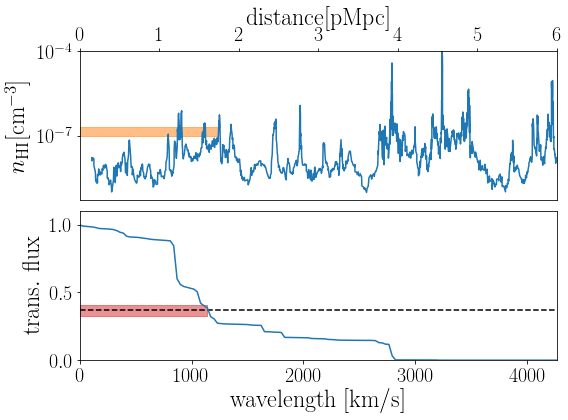

yt : [INFO     ] 2024-03-12 14:24:37,845 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:37,846 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:37,847 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:37,848 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:37,849 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:37,849 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:37,850 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:37,851 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:37,852 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:37,852 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.93912692e-01 9.76890415e-01 9.72565430e-01 ... 9.95482196e+02
 9.95485136e+02 9.95486125e+02]
0.4418168531850259
17.322741555012737


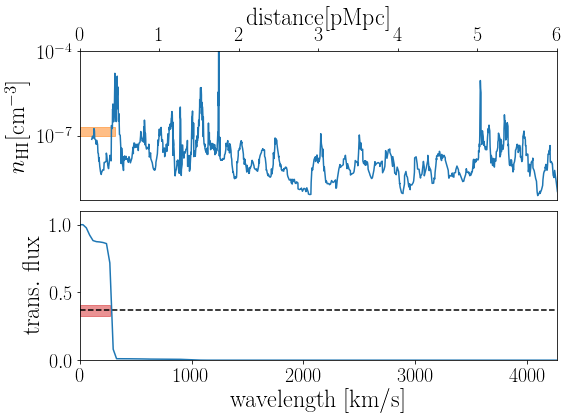

yt : [INFO     ] 2024-03-12 14:24:39,679 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:39,680 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:39,681 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:39,682 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:39,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:39,683 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:39,684 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:39,685 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:39,686 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:39,686 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[ 0.97964664  0.92151673  0.9189539  ... 38.43095631 38.43326273
 38.4368219 ]
1.111697137968601
17.00309130251147


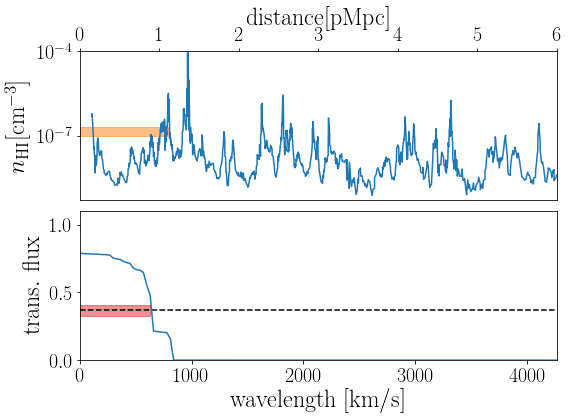

yt : [INFO     ] 2024-03-12 14:24:41,435 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:41,436 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:41,436 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:41,437 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:41,438 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:41,439 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:41,440 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:41,440 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:41,441 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:41,442 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.96919659e-01 9.95265423e-01 9.89581405e-01 ... 1.51683244e+03
 1.51683350e+03 1.51683384e+03]
2.0299374038892575
16.693274140164103


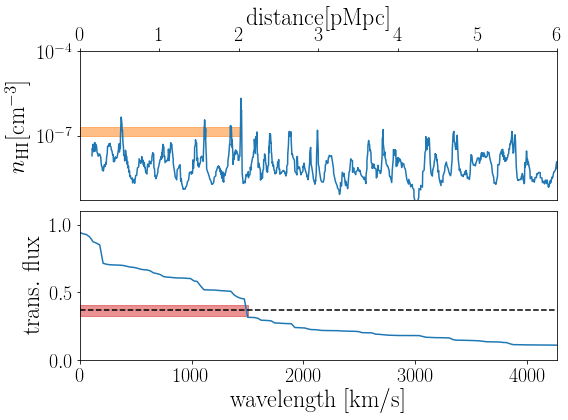

yt : [INFO     ] 2024-03-12 14:24:43,341 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:43,342 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:43,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:43,344 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:43,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:43,346 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:43,347 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:43,347 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:43,348 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:43,349 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[  0.99749415   0.99552807   0.99534623 ... 187.5635838  187.57544491
 187.59740926]
3.2945730192832907
17.690086739469386


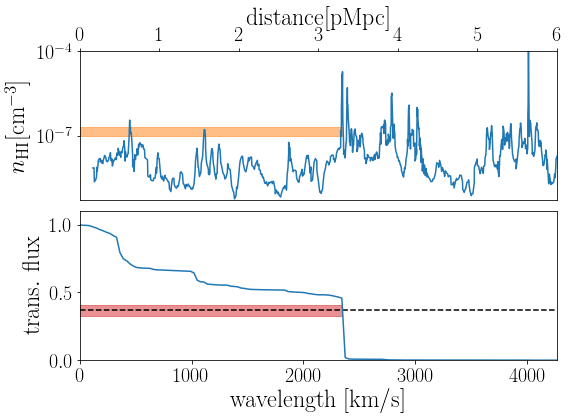

yt : [INFO     ] 2024-03-12 14:24:45,016 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:45,017 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:45,018 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:45,019 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:45,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:45,020 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:45,021 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:45,022 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:45,022 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:45,023 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[ 0.99923967  0.99811183  0.99667134 ... 39.39044007 39.39612174
 39.39636311]
3.5727400755882415
17.352572498642754


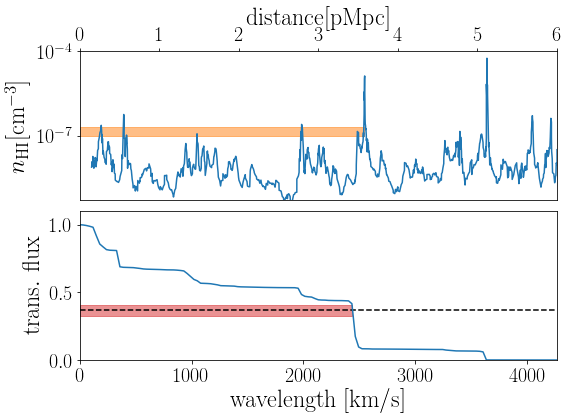

yt : [INFO     ] 2024-03-12 14:24:46,752 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:46,753 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:46,754 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:46,755 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:46,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:46,756 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:46,757 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:46,758 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:46,759 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:46,759 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.99217228e-01 9.98683884e-01 9.96429162e-01 ... 4.39741062e+03
 4.39741087e+03 4.39741137e+03]
2.5913912896392577
16.656265321226975


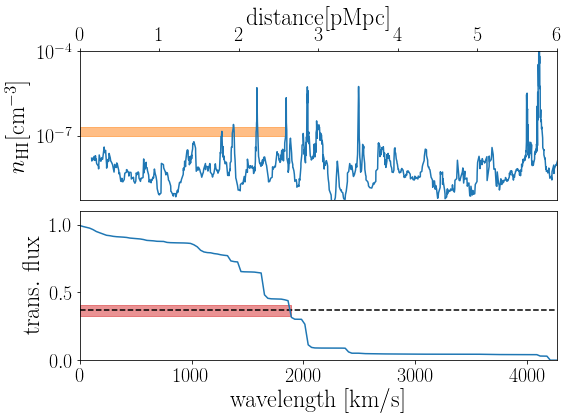

yt : [INFO     ] 2024-03-12 14:24:48,674 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:48,675 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:48,676 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:48,677 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:48,678 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:48,679 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:48,679 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:48,680 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:48,681 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:48,682 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[ 0.99984882  0.9997852   0.99892687 ... 44.08168002 44.08877673
 44.09184397]
3.117871362999115
15.385444848144417


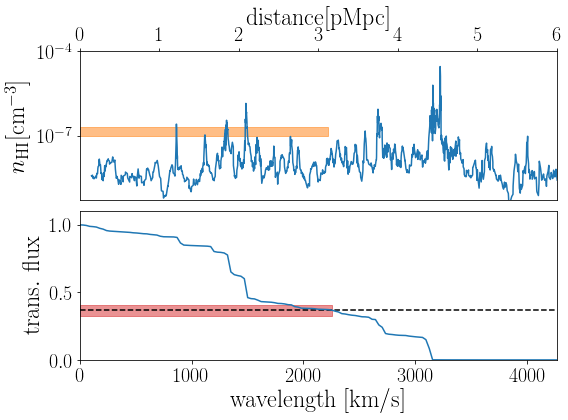

yt : [INFO     ] 2024-03-12 14:24:50,813 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:50,814 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:50,815 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:50,816 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:50,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:50,818 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:50,819 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:50,819 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:50,820 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:50,821 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.99383270e-01 9.98314902e-01 9.98072454e-01 ... 2.26388803e+03
 2.26388868e+03 2.26388915e+03]
0.6320015163233501
17.471509289821054


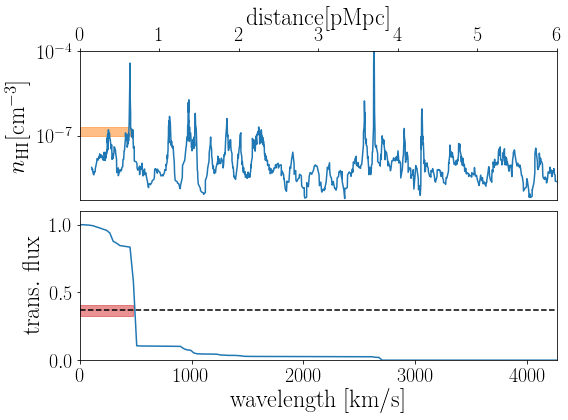

yt : [INFO     ] 2024-03-12 14:24:52,709 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:52,710 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:52,711 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:52,712 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:52,713 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:52,714 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:52,714 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:52,715 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:52,716 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:52,716 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[  0.99757783   0.99692571   0.99499371 ... 497.93364627 497.93570356
 497.93584241]
2.8867273002509855
16.92190067453567


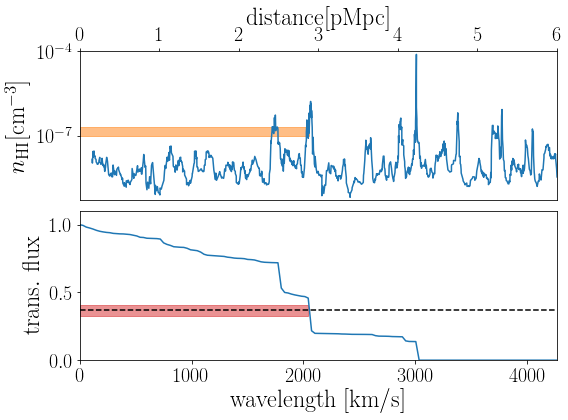

yt : [INFO     ] 2024-03-12 14:24:54,551 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:54,552 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:54,553 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:54,554 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:54,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:54,555 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:54,556 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:54,557 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:54,557 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:54,558 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.11457935e-01 8.24197023e-01 7.41823226e-01 ... 2.17739110e+04
 2.17739132e+04 2.17739164e+04]
0.20336543927359163
18.346401630653926


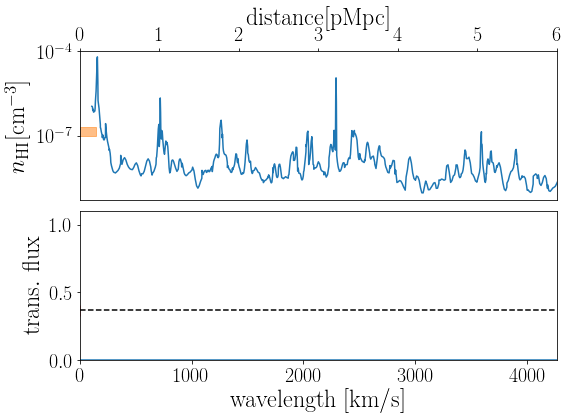

yt : [INFO     ] 2024-03-12 14:24:56,115 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:56,116 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:56,117 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:56,118 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:56,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:56,120 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:56,120 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:56,121 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:56,122 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:56,123 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.98766373e-01 9.98614135e-01 9.97571432e-01 ... 4.61229550e+03
 4.61229635e+03 4.61229638e+03]
2.310060100216338
17.55958434119787


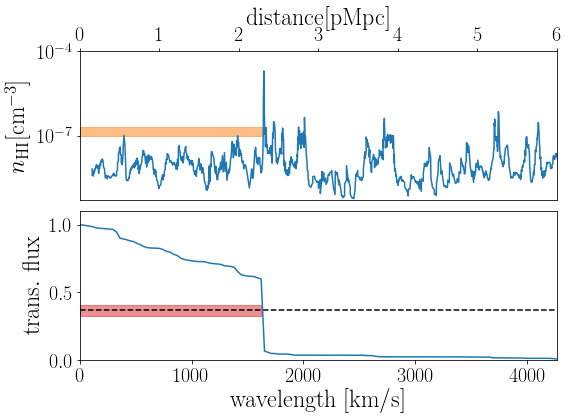

yt : [INFO     ] 2024-03-12 14:24:58,127 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:58,128 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:58,129 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:58,130 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:58,131 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:58,132 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:58,132 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:58,133 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:58,134 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:58,135 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.99209641e-01 9.98695516e-01 9.97527991e-01 ... 1.04525399e+03
 1.04525428e+03 1.04525452e+03]
2.5737928468432707
20.071026233829357


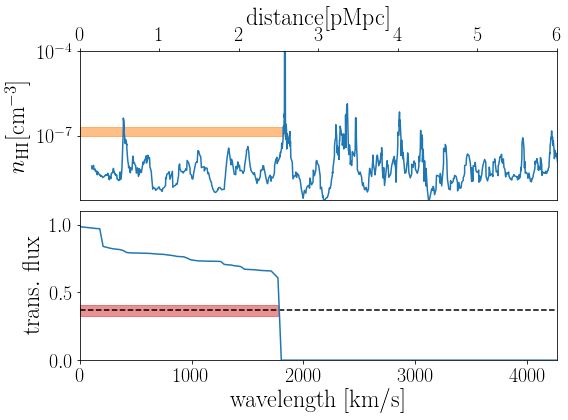

yt : [INFO     ] 2024-03-12 14:24:59,871 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:24:59,871 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:24:59,872 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:24:59,873 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:24:59,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:24:59,875 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:24:59,876 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:24:59,876 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:24:59,877 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:24:59,878 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[ 0.99583525  0.99406793  0.98661708 ... 55.10618689 55.10655322
 55.10684064]
5.268257635642643
15.010089742166615


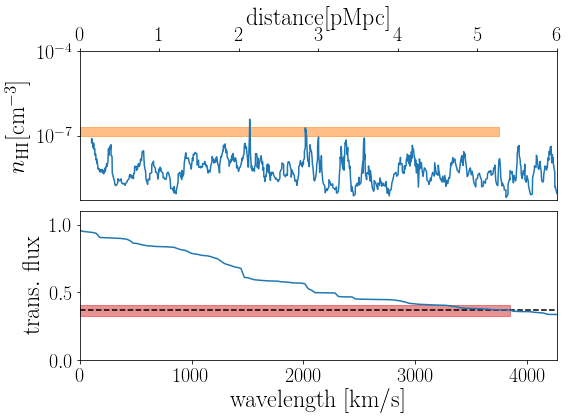

yt : [INFO     ] 2024-03-12 14:25:01,716 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:25:01,717 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:25:01,718 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:25:01,719 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:25:01,720 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:25:01,721 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:25:01,722 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:25:01,722 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:25:01,723 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:25:01,724 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.92073233e-01 9.83933812e-01 9.74805924e-01 ... 2.51625999e+03
 2.51626447e+03 2.51627041e+03]
0.6000960176237433
19.706670813730597


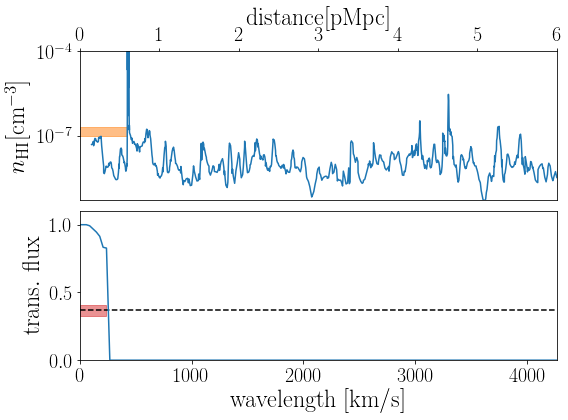

yt : [INFO     ] 2024-03-12 14:25:03,374 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:25:03,375 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:25:03,376 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:25:03,377 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:25:03,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:25:03,379 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:25:03,379 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:25:03,380 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:25:03,381 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:25:03,382 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[  0.99853886   0.99834972   0.99798918 ... 323.30107347 323.30187103
 323.30570845]
0.8022368621080793
18.337759694321033


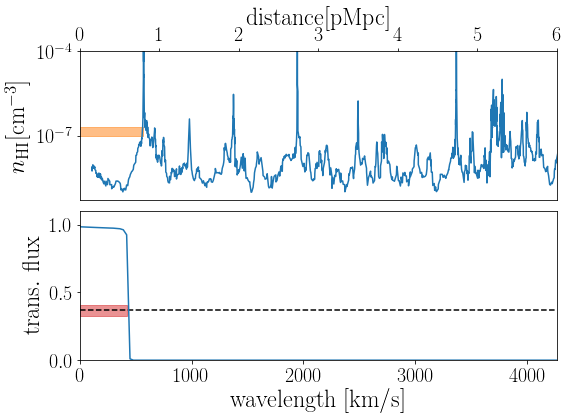

yt : [INFO     ] 2024-03-12 14:25:05,455 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:25:05,456 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:25:05,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:25:05,458 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:25:05,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:25:05,460 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:25:05,460 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:25:05,461 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:25:05,462 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:25:05,463 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.97443459e-01 9.96630598e-01 9.95531872e-01 ... 1.30752734e+03
 1.30753068e+03 1.30753070e+03]
5.212069421371494
15.838753981754571


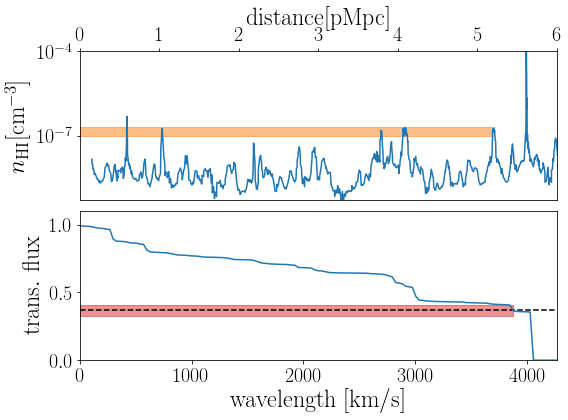

yt : [INFO     ] 2024-03-12 14:25:07,307 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-12 14:25:07,308 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-12 14:25:07,309 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-12 14:25:07,310 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-12 14:25:07,311 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-12 14:25:07,312 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-12 14:25:07,313 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-12 14:25:07,314 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-12 14:25:07,314 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-12 14:25:07,315 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

[9.98663833e-01 9.98549124e-01 9.97103954e-01 ... 1.40861795e+03
 1.40862004e+03 1.40862169e+03]
4.623778786363197
16.12725499610025


In [ ]:
mfp_sim_def=[]
tau_profiles=[]
losList=glob.glob(rootpath+folder+"lightray*h5")
for i,losName in enumerate(losList[::10]):
    los=yt.load(losName)
    dr=los.r["dl"].to("Mpc").value
    dist=np.cumsum(los.r["dl"].to("Mpc").value)
    nHI=(los.r['gas','RT_HVAR_HI']/yt.units.mp).in_units("cm**-3").v
    vlos=los.r['gas','velocity_los'].to("km/s").v
    cut_inner=0.15
    taup=integ_tau(vout,dist[dist>cut_inner],nHI[dist>cut_inner],vlos[dist>cut_inner],dr[dist>cut_inner],Hz)
    
    
    cumsum=np.cumsum(dr[dist>cut_inner]*nHI[dist>cut_inner]*3.08e24)
    print(np.abs(cumsum*sigmaHI-1))
    index=np.argmin(np.abs(cumsum*sigmaHI-1))
    print(dist[dist>cut_inner][index])
    print(np.log10(np.sum((dr[dist>cut_inner]*nHI[dist>cut_inner])[index:index+10]*3.08e24)))
    
    
    tau_profiles.append(taup)
    fig,ax=plt.subplots(figsize=(8,6),nrows=2)
    ax[0].plot(dist[dist>cut_inner],nHI[dist>cut_inner])
    ax[0].set_yscale("log")
    ax[0].set_xlim(0,6)
    ax[0].set_ylim(5e-10,1e-4)
    ax[0].set_xlabel(r"$\rm distance [pMpc]$")
    ax[0].xaxis.set_label_coords(0.5, 1.3)
    ax[0].set_ylabel(r"$n_{\rm HI} \rm [cm^{-3}]$")
    ax[0].xaxis.set_ticks_position('top')
    ax[0].fill_betweenx([1e-7,2e-7],0,dist[dist>cut_inner][index],color="tab:orange",alpha=0.5)
#     ax[0].xaxis.set_label_position('top')
    ax[1].plot(vout,np.exp(-taup))
    ax[1].set_xlim(0,6*Hz)
    ax[1].set_xlabel(r"$\rm wavelength ~ [km/s]$")
    ax[1].set_ylabel(r"$\rm trans. \ flux$")
    ax[1].hlines(np.exp(-1),0,10*Hz,linestyle='--')
    ax[1].fill_betweenx([1/np.e-0.04,1/np.e+0.04],0,vout[np.argmin(np.abs(taup-1))],color="tab:red",alpha=0.5)
    ax[1].set_ylim(0,1.1)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout()
    plt.savefig(str(i)+".png")
    plt.show()

In [40]:
ax[0].fill_betweenx

Object `fill_betweenx` not found.


In [ ]:
ax[0].fill_betweenx

In [24]:
# np.save("tau_profiles_F_a0.1287.npy",tau_profiles)

In [25]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [15]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

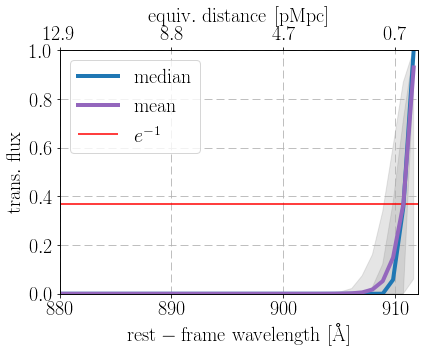

In [21]:
fig=plt.figure(figsize=(6,5))
ax=fig.subplots()
AA_tau1_list_Fz58=[]

flux_mat=np.exp(-np.array(tau_profiles))
plt.plot(AAout,np.median(flux_mat,axis=0),c="tab:blue",label=r"$\rm median$",lw=4)

plt.plot(AAout,np.mean(flux_mat,axis=0),c="tab:purple",label=r"$\rm mean$",lw=4)


plt.fill_between(AAout,np.percentile(flux_mat,84,axis=0),np.percentile(flux_mat,16,axis=0),\
                 color="grey",alpha=0.2)
plt.fill_between(AAout,np.percentile(flux_mat,97.5,axis=0),np.percentile(flux_mat,2.5,axis=0),\
                 color="grey",alpha=0.2)


plt.hlines(np.exp(-1),820,912,color='r',label=r"$e^{-1}$")

# for tp in tau_profiles:
#     plt.plot(AAout,np.exp(-tp),c="tab:blue",alpha=0.01)
#     AA_tau1=AAout[np.where(tp>1)[0][0]]
#     AA_tau1_list_Fz58.append(AA_tau1)
plt.ylim(0,1)
plt.xlim(880,912)
plt.grid(dashes=(10,5))
plt.legend()
plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")

ax2 = ax.twiny()
new_tick_locations = np.linspace(880,910,4)  # Adjust these as needed
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
labels=clight_kmps*(911.6485294117647-new_tick_locations)/911.6485294117647/Hz
labels=[r"${:.1f}$".format(d) for d in labels]
ax2.set_xticklabels(labels)  # Adjust labels as needed
ax2.set_xlabel(r"$\rm equiv. \ distance \ [pMpc]$")
plt.tight_layout()
# plt.savefig("no_qso_spec_scatter_z63.pdf")

In [18]:
# np.save("/data/hqchen/mfp_project/data/tau_profiles_noq_z61.npy",tau_profiles)


In [24]:
mfp_pMpc_z525=(eV2lambdaAA(13.6)-np.array(AA_tau1_list))/eV2lambdaAA(13.6)*clight_kmps/Hz

mfp_pMpc_Fz52=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz52))/eV2lambdaAA(13.6)*clight_kmps/Hz

mfp_pMpc_Fz61=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz61))/eV2lambdaAA(13.6)*clight_kmps/Hz
mfp_pMpc_Fz64=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz64))/eV2lambdaAA(13.6)*clight_kmps/Hz
mfp_pMpc_Fz68=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz68))/eV2lambdaAA(13.6)*clight_kmps/Hz


# plt.hist(mfp_pMpc_z525)
# plt.hist(mfp_pMpc_Fz52)
plt.hist(mfp_pMpc_Fz61)
plt.hist(mfp_pMpc_Fz64)
plt.hist(mfp_pMpc_Fz68,bins=10)
print(np.mean(mfp_pMpc_z525),np.median(mfp_pMpc_z525))
print(np.mean(mfp_pMpc_Fz52),np.median(mfp_pMpc_Fz52))
print(np.mean(mfp_pMpc_Fz61),np.median(mfp_pMpc_Fz61))
print(np.mean(mfp_pMpc_Fz64),np.median(mfp_pMpc_Fz64))
print(np.mean(mfp_pMpc_Fz68),np.median(mfp_pMpc_Fz68))

NameError: name 'AA_tau1_list' is not defined

(array([ 34.,   0., 477.,   0., 327.,   0.,   0., 142.,   0.,  20.]),
 array([0.        , 0.150257  , 0.30051401, 0.45077101, 0.60102802,
        0.75128502, 0.90154203, 1.05179903, 1.20205604, 1.35231304,
        1.50257005]),
 <BarContainer object of 10 artists>)

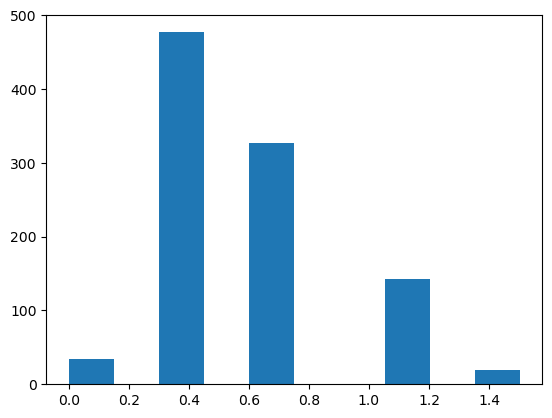

In [177]:
plt.hist(mfp_pMpc_Fz68,bins=10)

In [15]:
AAout

array([911.64852941, 910.72703482, 909.80554023, 908.88404564,
       907.96255105, 907.04105646, 906.11956187, 905.19806728,
       904.27657269, 903.3550781 , 902.43358351, 901.51208892,
       900.59059433, 899.66909974, 898.74760515, 897.82611056,
       896.90461597, 895.98312138, 895.06162679, 894.14013219,
       893.2186376 , 892.29714301, 891.37564842, 890.45415383,
       889.53265924, 888.61116465, 887.68967006, 886.76817547,
       885.84668088, 884.92518629, 884.0036917 , 883.08219711,
       882.16070252, 881.23920793, 880.31771334, 879.39621875,
       878.47472416, 877.55322957, 876.63173498, 875.71024039,
       874.7887458 , 873.86725121, 872.94575662, 872.02426203,
       871.10276744, 870.18127284, 869.25977825, 868.33828366,
       867.41678907, 866.49529448, 865.57379989, 864.6523053 ,
       863.73081071, 862.80931612, 861.88782153, 860.96632694,
       860.04483235, 859.12333776, 858.20184317, 857.28034858,
       856.35885399, 855.4373594 , 854.51586481, 853.59

3.244720589908742 2.5799527616555147


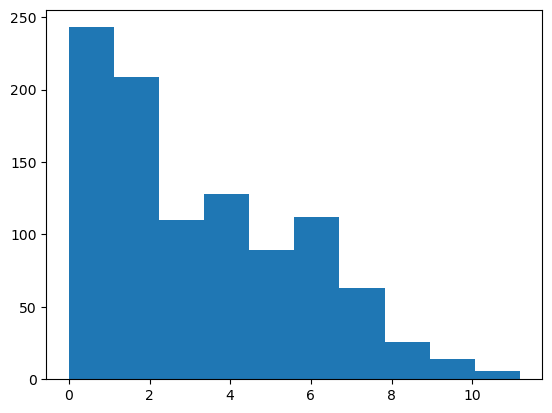

In [134]:
mfp_pMpc_z610=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_z610))/eV2lambdaAA(13.6)*clight_kmps/Hz
plt.hist(mfp_pMpc_z610)
print(np.mean(mfp_pMpc_z610),np.median(mfp_pMpc_z610))

(array([243., 209., 110., 128.,  89., 112.,  63.,  26.,  14.,   6.]),
 array([ 0.        ,  1.11797953,  2.23595906,  3.35393859,  4.47191812,
         5.58989765,  6.70787718,  7.82585671,  8.94383624, 10.06181577,
        11.1797953 ]),
 <BarContainer object of 10 artists>)

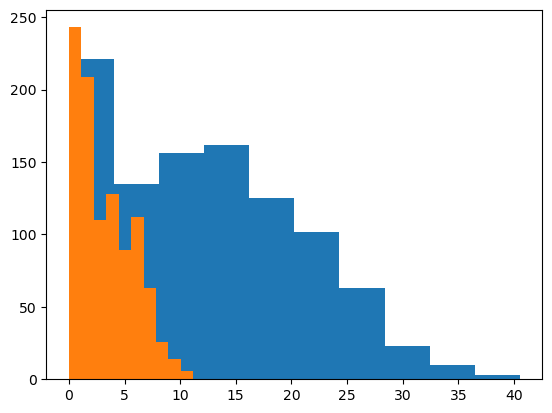

In [135]:
plt.hist(mfp_pMpc_z525,label="z=5.25")
plt.hist(mfp_pMpc_z610,label="z=6.10")

In [136]:
# np.save("tau_profiles_C_a0.1409.npy",tau_profiles)
# np.save("tau_profiles_C_a0.1600.npy",tau_profiles)
# np.savetxt("tau_profile_lambdaAA.txt",tau_profiles)

### quasar los

In [19]:
rootpath="/data/hqchen/mfp_project/data/"
zuni=1/0.1287-1
Hz=cosmo.H(zuni).value
print(zuni)
qsolos=h5py.File(rootpath+"sp17_1.4e+57_F_a01287_xT.hdf5",'r')


folder="F_a0.1287_50pMpc/"


6.770007770007769


In [15]:
qso_t1e7_tau_profiles=[]

for losName in list(qsolos.keys())[:]:
    loslong=yt.load(rootpath+folder+losName+".h5")
    drlong=loslong.r["dl"].to("Mpc").value
    distlong=np.cumsum(loslong.r["dl"].to("Mpc").value)
    nHIlong=(loslong.r['gas','RT_HVAR_HI']/yt.units.mp).in_units("cm**-3").v
    vloslong=loslong.r['gas','velocity_los'].to("km/s").v
    cut_inner=0.15

    
    losinfo=qsolos[losName+'/los.info'][:]
    dist=losinfo[:,0]
    dr=losinfo[:,1]
    xT=qsolos[losName+'/xT_1e7yr'][:]
    nHI_t1e7=losinfo[:,2]*xT[:,1]
    vlos=losinfo[:,-1]
    
    dist_stitch=np.array(list(dist)+list(distlong[distlong>dist[-1]]))
    dr_stitch=np.array(list(dr)+list(drlong[distlong>dist[-1]]))
    nHI_t1e7_stitch=np.array(list(nHI_t1e7)+list(nHIlong[distlong>dist[-1]]))
    vlos_stitch=np.array(list(vlos)+list(vloslong[distlong>dist[-1]]))
    
    qso_t1e7_tau_profiles.append(integ_tau(vout,dist_stitch,nHI_t1e7_stitch,vlos_stitch,dr_stitch,Hz))

yt : [INFO     ] 2024-02-20 09:35:26,012 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:35:26,013 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:35:26,014 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:35:26,015 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:35:26,016 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:35:26,017 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:35:26,018 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:35:26,018 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:35:26,019 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:35:26,020 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:35:30,582 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:35:30,583 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:35:30,584 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:35:30,584 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:35:30,585 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:35:30,586 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:35:30,586 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:35:30,587 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:35:30,593 Allocating for 8.629e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:35:30,600 Identified 5.881e+03 octs
yt : [INFO     ] 2024-02-20 09:35:3

yt : [INFO     ] 2024-02-20 09:35:34,929 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:35:34,930 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:35:34,931 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:35:34,931 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:35:34,932 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:35:34,933 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:35:34,938 Allocating for 8.432e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:35:34,945 Identified 5.777e+03 octs
yt : [INFO     ] 2024-02-20 09:35:35,511 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:35:35,513 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:35:35,513 Parameters: domain

yt : [INFO     ] 2024-02-20 09:35:39,298 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:35:39,299 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:35:39,300 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:35:39,300 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:35:39,307 Allocating for 7.082e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:35:39,316 Identified 4.905e+03 octs
yt : [INFO     ] 2024-02-20 09:35:40,037 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:35:40,038 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:35:40,039 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:35:40,040 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:35:43,768 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:35:43,768 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:35:43,775 Allocating for 8.709e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:35:43,782 Identified 5.937e+03 octs
yt : [INFO     ] 2024-02-20 09:35:44,371 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:35:44,372 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:35:44,373 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:35:44,374 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:35:44,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:35:44,375 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:35:44,376 Para

yt : [INFO     ] 2024-02-20 09:35:47,856 Allocating for 8.316e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:35:47,863 Identified 5.553e+03 octs
yt : [INFO     ] 2024-02-20 09:35:48,590 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:35:48,592 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:35:48,593 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:35:48,594 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:35:48,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:35:48,596 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:35:48,597 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:35:48,597 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:35:48,598

yt : [INFO     ] 2024-02-20 09:35:52,682 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:35:52,683 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:35:52,684 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:35:52,685 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:35:52,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:35:52,686 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:35:52,687 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:35:52,688 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:35:52,689 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:35:52,689 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:35:57,024 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:35:57,025 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:35:57,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:35:57,026 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:35:57,027 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:35:57,027 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:35:57,028 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:35:57,029 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:35:57,035 Allocating for 8.225e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:35:57,041 Identified 5.457e+03 octs
yt : [INFO     ] 2024-02-20 09:35:5

yt : [INFO     ] 2024-02-20 09:36:01,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:01,395 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:01,395 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:01,396 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:01,397 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:01,397 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:01,403 Allocating for 7.099e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:01,410 Identified 4.609e+03 octs
yt : [INFO     ] 2024-02-20 09:36:01,961 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:01,963 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:01,964 Parameters: domain

yt : [INFO     ] 2024-02-20 09:36:05,709 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:05,710 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:05,710 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:05,711 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:05,717 Allocating for 8.722e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:05,724 Identified 6.033e+03 octs
yt : [INFO     ] 2024-02-20 09:36:06,453 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:06,454 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:06,455 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:06,456 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:36:10,153 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:10,154 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:10,161 Allocating for 7.160e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:10,168 Identified 4.513e+03 octs
yt : [INFO     ] 2024-02-20 09:36:10,692 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:10,693 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:10,694 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:10,695 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:10,696 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:10,696 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:10,697 Para

yt : [INFO     ] 2024-02-20 09:36:14,420 Allocating for 8.073e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:14,427 Identified 5.473e+03 octs
yt : [INFO     ] 2024-02-20 09:36:14,999 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:15,001 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:15,002 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:15,003 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:15,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:15,004 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:15,005 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:15,005 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:15,006

yt : [INFO     ] 2024-02-20 09:36:19,313 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:19,314 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:19,315 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:19,316 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:19,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:19,318 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:19,318 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:19,319 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:19,320 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:19,320 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:36:23,536 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:23,537 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:23,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:23,539 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:23,539 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:23,540 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:23,541 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:23,542 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:23,548 Allocating for 9.179e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:23,555 Identified 5.617e+03 octs
yt : [INFO     ] 2024-02-20 09:36:2

yt : [INFO     ] 2024-02-20 09:36:28,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:28,004 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:28,004 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:28,005 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:28,006 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:28,006 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:28,012 Allocating for 8.711e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:28,018 Identified 5.777e+03 octs
yt : [INFO     ] 2024-02-20 09:36:28,597 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:28,598 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:28,599 Parameters: domain

yt : [INFO     ] 2024-02-20 09:36:32,569 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:32,570 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:32,570 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:32,571 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:32,577 Allocating for 7.024e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:32,583 Identified 5.001e+03 octs
yt : [INFO     ] 2024-02-20 09:36:33,076 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:33,077 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:33,078 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:33,079 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:36:36,656 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:36,657 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:36,663 Allocating for 8.111e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:36,670 Identified 5.369e+03 octs
yt : [INFO     ] 2024-02-20 09:36:37,218 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:37,219 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:37,220 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:37,221 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:37,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:37,223 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:37,224 Para

yt : [INFO     ] 2024-02-20 09:36:40,744 Allocating for 8.214e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:40,752 Identified 5.577e+03 octs
yt : [INFO     ] 2024-02-20 09:36:41,330 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:41,331 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:41,332 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:41,333 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:41,333 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:41,334 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:41,335 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:41,335 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:41,336

yt : [INFO     ] 2024-02-20 09:36:45,523 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:45,524 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:45,525 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:45,526 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:45,527 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:45,528 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:45,528 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:45,529 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:45,530 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:45,530 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:36:49,618 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:49,619 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:36:49,620 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:49,620 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:49,621 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:49,622 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:49,622 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:49,623 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:49,629 Allocating for 6.847e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:49,636 Identified 4.753e+03 octs
yt : [INFO     ] 2024-02-20 09:36:5

yt : [INFO     ] 2024-02-20 09:36:53,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:36:53,557 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:36:53,557 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:53,558 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:53,559 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:53,559 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:53,566 Allocating for 7.883e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:53,572 Identified 5.345e+03 octs
yt : [INFO     ] 2024-02-20 09:36:54,263 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:54,264 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:54,265 Parameters: domain

yt : [INFO     ] 2024-02-20 09:36:57,927 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:36:57,928 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:36:57,928 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:36:57,929 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:36:57,935 Allocating for 8.427e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:36:57,941 Identified 5.537e+03 octs
yt : [INFO     ] 2024-02-20 09:36:58,517 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:36:58,518 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:36:58,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:36:58,520 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:37:02,003 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:02,004 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:02,009 Allocating for 9.003e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:02,016 Identified 6.345e+03 octs
yt : [INFO     ] 2024-02-20 09:37:02,779 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:02,779 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:02,780 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:02,781 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:02,782 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:02,782 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:02,783 Para

yt : [INFO     ] 2024-02-20 09:37:06,755 Allocating for 8.712e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:06,762 Identified 5.969e+03 octs
yt : [INFO     ] 2024-02-20 09:37:07,331 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:07,332 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:07,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:07,334 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:07,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:07,335 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:07,336 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:07,336 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:07,337

yt : [INFO     ] 2024-02-20 09:37:11,546 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:11,547 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:11,548 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:11,549 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:11,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:11,550 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:11,551 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:11,552 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:11,552 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:11,553 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:37:15,713 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:15,713 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:15,714 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:15,715 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:15,716 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:15,716 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:15,717 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:15,718 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:15,723 Allocating for 8.805e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:15,729 Identified 5.609e+03 octs
yt : [INFO     ] 2024-02-20 09:37:1

yt : [INFO     ] 2024-02-20 09:37:19,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:19,970 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:19,971 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:19,971 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:19,972 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:19,973 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:19,978 Allocating for 7.329e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:19,984 Identified 4.649e+03 octs
yt : [INFO     ] 2024-02-20 09:37:20,509 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:20,510 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:20,511 Parameters: domain

yt : [INFO     ] 2024-02-20 09:37:24,170 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:24,171 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:24,171 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:24,172 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:24,329 Allocating for 8.760e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:24,336 Identified 5.881e+03 octs
yt : [INFO     ] 2024-02-20 09:37:24,918 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:24,919 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:24,920 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:24,921 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:37:28,437 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:28,438 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:28,443 Allocating for 9.029e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:28,450 Identified 6.321e+03 octs
yt : [INFO     ] 2024-02-20 09:37:29,055 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:29,057 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:29,058 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:29,059 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:29,059 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:29,060 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:29,061 Para

yt : [INFO     ] 2024-02-20 09:37:32,771 Allocating for 7.068e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:32,779 Identified 4.857e+03 octs
yt : [INFO     ] 2024-02-20 09:37:33,302 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:33,303 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:33,303 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:33,304 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:33,305 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:33,306 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:33,306 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:33,307 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:33,308

yt : [INFO     ] 2024-02-20 09:37:37,656 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:37,657 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:37,658 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:37,659 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:37,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:37,661 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:37,662 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:37,662 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:37,663 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:37,664 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:37:42,031 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:42,032 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:42,033 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:42,033 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:42,034 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:42,035 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:42,035 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:42,036 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:42,042 Allocating for 6.577e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:42,048 Identified 4.441e+03 octs
yt : [INFO     ] 2024-02-20 09:37:4

yt : [INFO     ] 2024-02-20 09:37:46,136 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:46,136 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:46,137 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:46,138 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:46,138 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:46,139 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:46,145 Allocating for 7.879e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:46,151 Identified 5.209e+03 octs
yt : [INFO     ] 2024-02-20 09:37:46,865 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:46,866 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:46,867 Parameters: domain

yt : [INFO     ] 2024-02-20 09:37:50,560 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:50,560 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:50,561 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:50,562 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:50,567 Allocating for 8.777e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:50,574 Identified 5.921e+03 octs
yt : [INFO     ] 2024-02-20 09:37:51,160 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:51,161 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:51,162 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:51,163 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:37:54,689 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:37:54,689 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:37:54,695 Allocating for 5.977e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:54,710 Identified 3.969e+03 octs
yt : [INFO     ] 2024-02-20 09:37:55,393 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:55,394 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:55,395 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:55,396 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:55,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:55,398 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:55,398 Para

yt : [INFO     ] 2024-02-20 09:37:59,114 Allocating for 9.142e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:37:59,122 Identified 6.473e+03 octs
yt : [INFO     ] 2024-02-20 09:37:59,719 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:37:59,720 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:37:59,721 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:37:59,722 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:37:59,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:37:59,723 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:37:59,724 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:37:59,724 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:37:59,725

yt : [INFO     ] 2024-02-20 09:38:03,724 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:03,725 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:03,726 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:03,727 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:03,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:03,728 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:03,729 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:03,730 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:03,730 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:03,731 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:38:07,956 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:07,957 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:07,958 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:07,959 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:07,960 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:07,960 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:07,961 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:07,962 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:07,968 Allocating for 8.922e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:07,983 Identified 5.481e+03 octs
yt : [INFO     ] 2024-02-20 09:38:0

yt : [INFO     ] 2024-02-20 09:38:12,234 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:12,235 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:12,236 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:12,236 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:12,237 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:12,238 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:12,243 Allocating for 7.810e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:12,250 Identified 5.329e+03 octs
yt : [INFO     ] 2024-02-20 09:38:12,973 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:12,974 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:12,975 Parameters: domain

yt : [INFO     ] 2024-02-20 09:38:16,594 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:16,595 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:16,596 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:16,596 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:16,602 Allocating for 8.616e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:16,608 Identified 5.553e+03 octs
yt : [INFO     ] 2024-02-20 09:38:17,183 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:17,184 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:17,185 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:17,186 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:38:20,865 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:20,865 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:20,871 Allocating for 7.940e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:20,877 Identified 5.305e+03 octs
yt : [INFO     ] 2024-02-20 09:38:21,434 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:21,435 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:21,435 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:21,436 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:21,437 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:21,437 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:21,438 Para

yt : [INFO     ] 2024-02-20 09:38:25,305 Allocating for 5.752e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:25,311 Identified 4.041e+03 octs
yt : [INFO     ] 2024-02-20 09:38:25,797 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:25,798 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:25,799 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:25,800 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:25,801 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:25,801 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:25,802 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:25,803 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:25,803

yt : [INFO     ] 2024-02-20 09:38:29,954 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:29,955 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:29,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:29,956 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:29,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:29,958 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:29,958 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:29,959 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:29,960 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:29,960 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:38:34,644 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:34,645 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:34,645 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:34,646 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:34,647 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:34,648 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:34,648 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:34,649 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:34,655 Allocating for 8.884e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:34,663 Identified 5.729e+03 octs
yt : [INFO     ] 2024-02-20 09:38:3

yt : [INFO     ] 2024-02-20 09:38:38,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:38,791 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:38,791 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:38,792 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:38,793 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:38,794 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:38,800 Allocating for 6.328e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:38,806 Identified 4.433e+03 octs
yt : [INFO     ] 2024-02-20 09:38:39,303 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:39,304 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:39,305 Parameters: domain

yt : [INFO     ] 2024-02-20 09:38:43,391 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:43,392 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:43,393 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:43,394 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:43,400 Allocating for 7.587e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:43,406 Identified 4.609e+03 octs
yt : [INFO     ] 2024-02-20 09:38:44,041 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:44,042 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:44,043 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:44,044 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:38:47,369 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:47,369 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:47,375 Allocating for 8.555e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:47,382 Identified 5.905e+03 octs
yt : [INFO     ] 2024-02-20 09:38:47,923 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:47,925 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:47,926 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:47,927 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:47,927 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:47,928 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:47,929 Para

yt : [INFO     ] 2024-02-20 09:38:51,252 Allocating for 7.719e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:51,259 Identified 5.169e+03 octs
yt : [INFO     ] 2024-02-20 09:38:51,776 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:51,778 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:51,779 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:51,780 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:51,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:51,782 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:51,783 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:51,783 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:51,784

yt : [INFO     ] 2024-02-20 09:38:55,851 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:38:55,853 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:38:55,853 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:55,854 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:55,855 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:55,856 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:55,857 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:55,858 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:55,858 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:55,859 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:38:59,833 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:38:59,834 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:38:59,835 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:38:59,835 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:38:59,836 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:38:59,837 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:38:59,838 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:38:59,838 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:38:59,844 Allocating for 7.484e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:38:59,850 Identified 5.177e+03 octs
yt : [INFO     ] 2024-02-20 09:39:0

yt : [INFO     ] 2024-02-20 09:39:03,804 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:03,805 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:03,805 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:03,806 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:03,807 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:03,808 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:03,815 Allocating for 7.563e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:03,822 Identified 5.017e+03 octs
yt : [INFO     ] 2024-02-20 09:39:04,340 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:04,341 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:04,342 Parameters: domain

yt : [INFO     ] 2024-02-20 09:39:07,775 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:07,776 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:07,777 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:07,778 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:07,783 Allocating for 8.706e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:07,790 Identified 6.033e+03 octs
yt : [INFO     ] 2024-02-20 09:39:08,341 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:08,342 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:08,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:08,344 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:39:12,093 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:12,094 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:12,099 Allocating for 7.713e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:12,105 Identified 5.217e+03 octs
yt : [INFO     ] 2024-02-20 09:39:12,844 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:12,846 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:12,846 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:12,847 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:12,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:12,849 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:12,849 Para

yt : [INFO     ] 2024-02-20 09:39:16,517 Allocating for 6.874e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:16,524 Identified 4.833e+03 octs
yt : [INFO     ] 2024-02-20 09:39:17,038 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:17,039 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:17,040 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:17,041 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:17,042 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:17,042 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:17,043 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:17,044 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:17,044

yt : [INFO     ] 2024-02-20 09:39:21,206 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:21,207 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:21,207 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:21,208 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:21,209 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:21,210 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:21,210 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:21,211 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:21,212 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:21,212 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:39:25,511 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:25,511 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:25,512 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:25,513 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:25,513 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:25,514 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:25,515 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:25,515 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:25,521 Allocating for 8.150e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:25,527 Identified 5.297e+03 octs
yt : [INFO     ] 2024-02-20 09:39:2

yt : [INFO     ] 2024-02-20 09:39:29,647 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:29,648 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:29,648 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:29,649 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:29,650 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:29,650 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:29,656 Allocating for 5.487e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:29,661 Identified 3.889e+03 octs
yt : [INFO     ] 2024-02-20 09:39:30,132 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:30,133 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:30,134 Parameters: domain

yt : [INFO     ] 2024-02-20 09:39:33,794 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:33,794 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:33,795 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:33,795 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:33,801 Allocating for 6.273e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:33,807 Identified 4.385e+03 octs
yt : [INFO     ] 2024-02-20 09:39:34,536 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:34,538 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:34,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:34,540 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:39:38,188 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:38,189 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:38,195 Allocating for 8.706e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:38,202 Identified 5.953e+03 octs
yt : [INFO     ] 2024-02-20 09:39:38,807 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:38,808 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:38,809 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:38,810 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:38,811 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:38,811 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:38,812 Para

yt : [INFO     ] 2024-02-20 09:39:42,562 Allocating for 7.324e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:42,568 Identified 4.745e+03 octs
yt : [INFO     ] 2024-02-20 09:39:43,086 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:43,088 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:43,089 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:43,089 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:43,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:43,091 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:43,092 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:43,092 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:43,093

yt : [INFO     ] 2024-02-20 09:39:47,825 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:47,827 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:47,828 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:47,829 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:47,830 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:47,831 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:47,831 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:47,832 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:47,832 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:47,833 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:39:52,237 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:39:52,238 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:39:52,239 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:52,240 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:52,240 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:52,241 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:52,242 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:52,242 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:52,249 Allocating for 8.824e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:52,256 Identified 6.073e+03 octs
yt : [INFO     ] 2024-02-20 09:39:5

yt : [INFO     ] 2024-02-20 09:39:56,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:39:56,496 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:39:56,497 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:39:56,497 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:39:56,498 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:39:56,499 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:39:56,505 Allocating for 7.249e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:39:56,511 Identified 5.033e+03 octs
yt : [INFO     ] 2024-02-20 09:39:57,048 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:39:57,049 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:39:57,050 Parameters: domain

yt : [INFO     ] 2024-02-20 09:40:00,722 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:00,723 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:00,723 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:00,724 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:00,730 Allocating for 5.870e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:00,736 Identified 4.041e+03 octs
yt : [INFO     ] 2024-02-20 09:40:01,445 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:01,447 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:01,448 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:01,448 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:40:05,238 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:05,239 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:05,245 Allocating for 7.680e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:05,253 Identified 5.249e+03 octs
yt : [INFO     ] 2024-02-20 09:40:05,809 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:05,811 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:05,812 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:05,812 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:05,813 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:05,814 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:05,815 Para

yt : [INFO     ] 2024-02-20 09:40:09,532 Allocating for 8.618e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:09,539 Identified 5.801e+03 octs
yt : [INFO     ] 2024-02-20 09:40:10,112 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:10,114 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:10,114 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:10,115 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:10,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:10,117 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:10,117 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:10,118 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:10,119

yt : [INFO     ] 2024-02-20 09:40:14,586 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:14,587 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:14,588 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:14,589 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:14,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:14,591 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:14,591 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:14,592 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:14,592 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:14,593 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:40:18,811 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:18,812 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:18,813 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:18,814 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:18,814 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:18,815 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:18,816 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:18,816 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:18,822 Allocating for 8.189e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:18,829 Identified 5.361e+03 octs
yt : [INFO     ] 2024-02-20 09:40:1

yt : [INFO     ] 2024-02-20 09:40:23,411 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:23,412 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:23,413 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:23,413 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:23,414 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:23,415 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:23,420 Allocating for 8.364e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:23,427 Identified 5.705e+03 octs
yt : [INFO     ] 2024-02-20 09:40:24,017 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:24,019 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:24,020 Parameters: domain

yt : [INFO     ] 2024-02-20 09:40:27,674 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:27,675 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:27,675 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:27,676 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:27,682 Allocating for 6.625e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:27,688 Identified 4.569e+03 octs
yt : [INFO     ] 2024-02-20 09:40:28,216 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:28,217 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:28,218 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:28,219 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:40:32,271 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:32,272 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:32,278 Allocating for 7.055e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:32,284 Identified 4.881e+03 octs
yt : [INFO     ] 2024-02-20 09:40:32,813 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:32,814 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:32,815 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:32,816 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:32,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:32,817 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:32,818 Para

yt : [INFO     ] 2024-02-20 09:40:36,416 Allocating for 6.902e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:36,425 Identified 4.601e+03 octs
yt : [INFO     ] 2024-02-20 09:40:36,972 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:36,974 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:36,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:36,976 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:36,977 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:36,977 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:36,978 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:36,978 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:36,979

yt : [INFO     ] 2024-02-20 09:40:41,278 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:41,280 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:41,281 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:41,282 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:41,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:41,283 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:41,284 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:41,285 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:41,285 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:41,286 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:40:45,586 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:45,587 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:45,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:45,588 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:45,589 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:45,590 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:45,590 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:45,591 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:45,599 Allocating for 8.412e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:45,605 Identified 5.369e+03 octs
yt : [INFO     ] 2024-02-20 09:40:4

yt : [INFO     ] 2024-02-20 09:40:50,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:50,294 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:50,295 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:50,295 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:50,296 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:50,297 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:50,302 Allocating for 8.645e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:50,309 Identified 6.057e+03 octs
yt : [INFO     ] 2024-02-20 09:40:50,907 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:50,909 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:50,910 Parameters: domain

yt : [INFO     ] 2024-02-20 09:40:54,734 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:40:54,734 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:40:54,735 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:54,736 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:54,741 Allocating for 7.730e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:54,748 Identified 5.033e+03 octs
yt : [INFO     ] 2024-02-20 09:40:55,318 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:55,319 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:55,320 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:55,321 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:40:58,980 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:40:58,980 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:40:58,986 Allocating for 7.293e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:40:58,992 Identified 4.921e+03 octs
yt : [INFO     ] 2024-02-20 09:40:59,517 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:40:59,519 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:40:59,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:40:59,520 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:40:59,521 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:40:59,522 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:40:59,522 Para

yt : [INFO     ] 2024-02-20 09:41:03,200 Allocating for 7.368e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:03,206 Identified 5.025e+03 octs
yt : [INFO     ] 2024-02-20 09:41:03,711 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:03,713 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:03,714 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:03,715 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:03,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:03,716 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:03,717 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:03,717 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:03,718

yt : [INFO     ] 2024-02-20 09:41:08,155 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:08,156 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:08,157 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:08,158 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:08,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:08,160 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:08,160 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:08,161 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:08,161 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:08,162 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:41:12,408 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:12,409 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:12,410 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:12,410 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:12,411 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:12,412 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:12,412 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:12,413 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:12,419 Allocating for 8.803e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:12,426 Identified 5.849e+03 octs
yt : [INFO     ] 2024-02-20 09:41:1

yt : [INFO     ] 2024-02-20 09:41:16,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:16,826 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:16,826 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:16,827 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:16,827 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:16,828 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:16,834 Allocating for 8.013e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:16,840 Identified 5.121e+03 octs
yt : [INFO     ] 2024-02-20 09:41:17,417 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:17,418 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:17,419 Parameters: domain

yt : [INFO     ] 2024-02-20 09:41:21,196 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:21,196 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:21,197 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:21,198 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:21,203 Allocating for 8.264e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:21,210 Identified 5.489e+03 octs
yt : [INFO     ] 2024-02-20 09:41:21,797 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:21,799 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:21,799 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:21,800 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:41:25,570 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:25,571 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:25,577 Allocating for 6.627e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:25,583 Identified 4.601e+03 octs
yt : [INFO     ] 2024-02-20 09:41:26,093 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:26,094 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:26,095 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:26,096 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:26,097 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:26,098 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:26,098 Para

yt : [INFO     ] 2024-02-20 09:41:29,827 Allocating for 8.842e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:29,834 Identified 5.761e+03 octs
yt : [INFO     ] 2024-02-20 09:41:30,694 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:30,695 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:30,696 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:30,697 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:30,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:30,698 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:30,699 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:30,700 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:30,700

yt : [INFO     ] 2024-02-20 09:41:35,047 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:35,048 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:35,049 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:35,050 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:35,051 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:35,052 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:35,052 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:35,053 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:35,054 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:35,054 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:41:39,475 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:39,476 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:39,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:39,478 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:39,478 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:39,479 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:39,479 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:39,480 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:39,486 Allocating for 7.261e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:39,492 Identified 4.705e+03 octs
yt : [INFO     ] 2024-02-20 09:41:4

yt : [INFO     ] 2024-02-20 09:41:43,724 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:43,724 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:43,725 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:43,726 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:43,726 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:43,727 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:43,733 Allocating for 7.616e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:43,739 Identified 5.057e+03 octs
yt : [INFO     ] 2024-02-20 09:41:44,283 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:44,285 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:44,286 Parameters: domain

yt : [INFO     ] 2024-02-20 09:41:48,088 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:48,088 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:48,089 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:48,090 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:48,095 Allocating for 7.550e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:48,101 Identified 5.137e+03 octs
yt : [INFO     ] 2024-02-20 09:41:48,925 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:48,926 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:48,927 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:48,928 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:41:52,619 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:41:52,620 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:41:52,626 Allocating for 6.983e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:52,632 Identified 4.849e+03 octs
yt : [INFO     ] 2024-02-20 09:41:53,171 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:53,172 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:53,173 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:53,174 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:53,175 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:53,176 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:53,176 Para

yt : [INFO     ] 2024-02-20 09:41:56,902 Allocating for 7.603e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:41:56,909 Identified 4.985e+03 octs
yt : [INFO     ] 2024-02-20 09:41:57,450 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:41:57,451 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:41:57,452 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:41:57,453 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:41:57,454 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:41:57,455 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:41:57,455 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:41:57,456 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:41:57,457

yt : [INFO     ] 2024-02-20 09:42:01,879 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:01,881 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:01,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:01,883 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:01,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:01,884 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:01,885 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:01,886 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:01,886 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:01,887 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:42:06,164 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:06,164 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:06,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:06,166 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:06,167 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:06,167 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:06,168 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:06,169 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:06,174 Allocating for 8.404e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:06,181 Identified 5.705e+03 octs
yt : [INFO     ] 2024-02-20 09:42:0

yt : [INFO     ] 2024-02-20 09:42:10,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:10,461 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:10,461 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:10,462 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:10,462 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:10,463 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:10,468 Allocating for 8.659e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:10,475 Identified 5.897e+03 octs
yt : [INFO     ] 2024-02-20 09:42:11,056 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:11,057 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:11,058 Parameters: domain

yt : [INFO     ] 2024-02-20 09:42:14,758 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:14,758 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:14,759 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:14,760 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:14,766 Allocating for 7.734e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:14,772 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-20 09:42:15,609 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:15,611 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:15,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:15,612 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:42:19,285 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:19,286 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:19,292 Allocating for 8.173e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:19,299 Identified 5.569e+03 octs
yt : [INFO     ] 2024-02-20 09:42:19,882 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:19,883 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:19,884 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:19,885 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:19,886 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:19,886 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:19,887 Para

yt : [INFO     ] 2024-02-20 09:42:23,665 Allocating for 7.898e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:23,672 Identified 5.369e+03 octs
yt : [INFO     ] 2024-02-20 09:42:24,260 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:24,261 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:24,262 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:24,263 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:24,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:24,264 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:24,265 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:24,265 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:24,266

yt : [INFO     ] 2024-02-20 09:42:28,686 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:28,687 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:28,688 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:28,689 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:28,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:28,690 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:28,691 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:28,692 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:28,692 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:28,693 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:42:33,203 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:33,204 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:33,205 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:33,205 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:33,206 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:33,207 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:33,207 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:33,208 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:33,214 Allocating for 6.689e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:33,220 Identified 4.337e+03 octs
yt : [INFO     ] 2024-02-20 09:42:3

yt : [INFO     ] 2024-02-20 09:42:37,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:37,608 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:37,609 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:37,610 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:37,610 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:37,611 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:37,617 Allocating for 8.748e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:37,624 Identified 6.009e+03 octs
yt : [INFO     ] 2024-02-20 09:42:38,211 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:38,213 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:38,214 Parameters: domain

yt : [INFO     ] 2024-02-20 09:42:42,113 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:42,114 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:42,114 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:42,115 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:42,121 Allocating for 8.157e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:42,128 Identified 5.609e+03 octs
yt : [INFO     ] 2024-02-20 09:42:42,886 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:42,888 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:42,889 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:42,890 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:42:46,039 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:46,040 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:46,045 Allocating for 7.958e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:46,052 Identified 5.193e+03 octs
yt : [INFO     ] 2024-02-20 09:42:46,769 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:46,770 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:46,771 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:46,772 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:46,773 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:46,774 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:46,775 Para

yt : [INFO     ] 2024-02-20 09:42:50,150 Allocating for 7.891e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:50,157 Identified 5.217e+03 octs
yt : [INFO     ] 2024-02-20 09:42:50,695 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:50,696 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:50,697 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:50,698 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:50,699 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:50,700 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:50,700 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:50,701 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:50,702

yt : [INFO     ] 2024-02-20 09:42:54,622 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:42:54,623 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:42:54,624 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:54,625 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:54,626 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:54,627 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:54,627 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:54,628 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:54,629 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:54,630 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:42:58,568 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:42:58,569 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:42:58,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:42:58,571 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:42:58,572 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:42:58,572 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:42:58,573 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:42:58,574 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:42:58,580 Allocating for 7.663e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:42:58,586 Identified 5.033e+03 octs
yt : [INFO     ] 2024-02-20 09:42:5

yt : [INFO     ] 2024-02-20 09:43:02,449 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:02,450 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:02,451 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:02,451 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:02,452 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:02,453 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:02,458 Allocating for 7.655e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:02,465 Identified 4.521e+03 octs
yt : [INFO     ] 2024-02-20 09:43:03,202 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:03,204 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:03,205 Parameters: domain

yt : [INFO     ] 2024-02-20 09:43:06,894 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:06,895 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:06,896 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:06,897 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:06,902 Allocating for 8.920e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:06,920 Identified 6.033e+03 octs
yt : [INFO     ] 2024-02-20 09:43:07,693 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:07,694 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:07,695 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:07,696 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:43:11,289 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:11,290 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:11,297 Allocating for 8.665e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:11,304 Identified 5.601e+03 octs
yt : [INFO     ] 2024-02-20 09:43:11,896 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:11,897 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:11,897 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:11,899 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:11,900 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:11,900 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:11,901 Para

yt : [INFO     ] 2024-02-20 09:43:15,554 Allocating for 8.840e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:15,560 Identified 6.049e+03 octs
yt : [INFO     ] 2024-02-20 09:43:16,445 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:16,446 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:16,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:16,448 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:16,449 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:16,450 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:16,450 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:16,451 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:16,452

yt : [INFO     ] 2024-02-20 09:43:21,013 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:21,014 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:21,015 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:21,016 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:21,017 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:21,018 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:21,019 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:21,019 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:21,020 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:21,021 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:43:25,454 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:25,455 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:25,456 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:25,456 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:25,457 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:25,458 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:25,459 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:25,459 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:25,466 Allocating for 8.066e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:25,474 Identified 5.465e+03 octs
yt : [INFO     ] 2024-02-20 09:43:2

yt : [INFO     ] 2024-02-20 09:43:29,829 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:29,830 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:29,831 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:29,831 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:29,832 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:29,833 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:29,839 Allocating for 8.099e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:29,846 Identified 5.313e+03 octs
yt : [INFO     ] 2024-02-20 09:43:30,424 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:30,426 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:30,427 Parameters: domain

yt : [INFO     ] 2024-02-20 09:43:34,101 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:34,101 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:34,102 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:34,103 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:34,109 Allocating for 7.258e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:34,116 Identified 4.665e+03 octs
yt : [INFO     ] 2024-02-20 09:43:34,662 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:34,663 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:34,664 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:34,665 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:43:38,623 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:38,624 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:38,630 Allocating for 8.631e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:38,638 Identified 5.953e+03 octs
yt : [INFO     ] 2024-02-20 09:43:39,213 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:39,214 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:39,215 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:39,216 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:39,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:39,217 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:39,218 Para

yt : [INFO     ] 2024-02-20 09:43:43,039 Allocating for 7.467e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:43,046 Identified 4.977e+03 octs
yt : [INFO     ] 2024-02-20 09:43:43,583 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:43,584 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:43,585 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:43,587 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:43,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:43,589 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:43,589 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:43,590 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:43,591

yt : [INFO     ] 2024-02-20 09:43:47,877 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:47,878 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:47,880 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:47,880 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:47,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:47,882 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:47,883 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:47,884 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:47,885 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:47,885 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:43:52,141 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:43:52,142 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:43:52,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:52,144 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:52,145 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:52,146 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:52,146 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:52,147 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:52,153 Allocating for 7.736e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:52,159 Identified 5.257e+03 octs
yt : [INFO     ] 2024-02-20 09:43:5

yt : [INFO     ] 2024-02-20 09:43:56,528 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:43:56,529 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:43:56,530 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:43:56,531 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:43:56,531 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:43:56,532 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:43:56,538 Allocating for 6.216e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:43:56,544 Identified 4.297e+03 octs
yt : [INFO     ] 2024-02-20 09:43:57,028 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:43:57,030 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:43:57,031 Parameters: domain

yt : [INFO     ] 2024-02-20 09:44:00,812 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:00,813 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:00,814 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:00,815 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:00,821 Allocating for 7.504e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:00,828 Identified 5.001e+03 octs
yt : [INFO     ] 2024-02-20 09:44:01,386 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:01,387 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:01,388 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:01,389 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:44:05,122 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:05,123 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:05,129 Allocating for 8.301e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:05,136 Identified 5.409e+03 octs
yt : [INFO     ] 2024-02-20 09:44:05,704 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:05,705 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:05,706 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:05,708 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:05,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:05,710 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:05,710 Para

yt : [INFO     ] 2024-02-20 09:44:09,611 Allocating for 6.450e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:09,617 Identified 4.441e+03 octs
yt : [INFO     ] 2024-02-20 09:44:10,128 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:10,130 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:10,131 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:10,132 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:10,133 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:10,134 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:10,134 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:10,135 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:10,136

yt : [INFO     ] 2024-02-20 09:44:14,545 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:14,546 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:14,547 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:14,548 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:14,549 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:14,549 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:14,550 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:14,551 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:14,552 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:14,553 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:44:19,275 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:19,276 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:19,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:19,278 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:19,279 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:19,279 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:19,280 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:19,281 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:19,287 Allocating for 8.005e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:19,295 Identified 5.377e+03 octs
yt : [INFO     ] 2024-02-20 09:44:1

yt : [INFO     ] 2024-02-20 09:44:23,307 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:23,308 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:23,308 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:23,309 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:23,310 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:23,311 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:23,317 Allocating for 7.475e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:23,324 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-20 09:44:24,192 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:24,194 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:24,195 Parameters: domain

yt : [INFO     ] 2024-02-20 09:44:27,717 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:27,717 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:27,718 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:27,719 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:27,725 Allocating for 8.074e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:27,731 Identified 5.305e+03 octs
yt : [INFO     ] 2024-02-20 09:44:28,607 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:28,609 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:28,610 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:28,611 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:44:32,596 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:32,597 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:32,603 Allocating for 7.609e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:32,610 Identified 5.225e+03 octs
yt : [INFO     ] 2024-02-20 09:44:33,167 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:33,169 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:33,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:33,171 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:33,172 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:33,173 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:33,174 Para

yt : [INFO     ] 2024-02-20 09:44:36,949 Allocating for 8.581e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:36,956 Identified 5.401e+03 octs
yt : [INFO     ] 2024-02-20 09:44:37,549 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:37,551 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:37,552 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:37,553 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:37,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:37,555 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:37,556 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:37,556 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:37,557

yt : [INFO     ] 2024-02-20 09:44:41,971 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:41,972 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:41,973 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:41,974 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:41,975 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:41,976 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:41,977 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:41,977 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:41,978 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:41,979 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:44:46,394 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:46,395 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:44:46,396 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:46,397 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:46,398 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:46,398 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:46,399 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:46,400 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:46,408 Allocating for 8.967e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:46,418 Identified 5.969e+03 octs
yt : [INFO     ] 2024-02-20 09:44:4

yt : [INFO     ] 2024-02-20 09:44:50,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:44:50,940 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:44:50,941 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:50,941 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:50,942 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:50,943 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:50,950 Allocating for 6.584e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:50,957 Identified 4.329e+03 octs
yt : [INFO     ] 2024-02-20 09:44:51,486 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:51,488 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:51,489 Parameters: domain

yt : [INFO     ] 2024-02-20 09:44:55,314 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:44:55,315 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:44:55,315 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:55,316 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:55,323 Allocating for 8.316e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:55,331 Identified 5.601e+03 octs
yt : [INFO     ] 2024-02-20 09:44:55,917 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:44:55,919 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:44:55,920 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:44:55,921 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:44:59,748 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:44:59,748 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:44:59,755 Allocating for 6.876e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:44:59,763 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-20 09:45:00,279 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:00,281 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:00,282 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:00,283 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:00,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:00,285 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:00,286 Para

yt : [INFO     ] 2024-02-20 09:45:04,074 Allocating for 7.592e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:45:04,082 Identified 5.089e+03 octs
yt : [INFO     ] 2024-02-20 09:45:04,646 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:04,648 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:04,649 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:04,650 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:04,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:04,652 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:04,652 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:04,653 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:04,654

yt : [INFO     ] 2024-02-20 09:45:08,915 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:08,916 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:08,917 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:08,918 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:08,919 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:08,920 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:08,921 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:08,921 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:08,922 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:45:08,923 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:45:13,487 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:13,489 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:13,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:13,490 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:13,491 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:13,492 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:13,493 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:45:13,493 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:45:13,500 Allocating for 5.713e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:45:13,506 Identified 3.945e+03 octs
yt : [INFO     ] 2024-02-20 09:45:1

yt : [INFO     ] 2024-02-20 09:45:18,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:18,024 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:18,025 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:18,025 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:18,026 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:45:18,027 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:45:18,033 Allocating for 8.126e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:45:18,040 Identified 5.497e+03 octs
yt : [INFO     ] 2024-02-20 09:45:18,639 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:18,640 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:18,641 Parameters: domain

yt : [INFO     ] 2024-02-20 09:45:22,474 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:22,475 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:22,475 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:45:22,476 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:45:22,482 Allocating for 8.035e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:45:22,490 Identified 5.561e+03 octs
yt : [INFO     ] 2024-02-20 09:45:23,081 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:23,082 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:23,083 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:23,087 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09

yt : [ERROR    ] 2024-02-20 09:45:26,899 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:45:26,900 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:45:26,906 Allocating for 8.017e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:45:26,913 Identified 5.617e+03 octs
yt : [INFO     ] 2024-02-20 09:45:27,485 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:27,486 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:27,487 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:27,488 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:27,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:27,490 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:27,491 Para

yt : [INFO     ] 2024-02-20 09:45:31,221 Allocating for 7.830e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:45:31,228 Identified 5.161e+03 octs
yt : [INFO     ] 2024-02-20 09:45:31,767 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:31,769 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:31,770 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:31,771 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:31,772 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:31,772 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:31,773 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:31,774 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:31,774

yt : [INFO     ] 2024-02-20 09:45:35,786 Parameters: current_time              = 798122927.997215 yr
yt : [INFO     ] 2024-02-20 09:45:35,787 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-20 09:45:35,787 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:35,788 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:35,789 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:35,790 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:35,791 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:35,791 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:35,792 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:45:35,793 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-20 09:45:39,671 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-20 09:45:39,672 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-20 09:45:39,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-20 09:45:39,673 Parameters: current_redshift          = 6.771727664875785
yt : [INFO     ] 2024-02-20 09:45:39,674 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-20 09:45:39,675 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-20 09:45:39,675 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-20 09:45:39,676 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-20 09:45:39,682 Allocating for 9.387e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-20 09:45:39,690 Identified 5.097e+03 octs
yt : [INFO     ] 2024-02-20 09:45:4

In [73]:
AAout

array([911.64852941, 910.72703482, 909.80554023, 908.88404564,
       907.96255105, 907.04105646, 906.11956187, 905.19806728,
       904.27657269, 903.3550781 , 902.43358351, 901.51208892,
       900.59059433, 899.66909974, 898.74760515, 897.82611056,
       896.90461597, 895.98312138, 895.06162679, 894.14013219,
       893.2186376 , 892.29714301, 891.37564842, 890.45415383,
       889.53265924, 888.61116465, 887.68967006, 886.76817547,
       885.84668088, 884.92518629, 884.0036917 , 883.08219711,
       882.16070252, 881.23920793, 880.31771334, 879.39621875,
       878.47472416, 877.55322957, 876.63173498, 875.71024039,
       874.7887458 , 873.86725121, 872.94575662, 872.02426203,
       871.10276744, 870.18127284, 869.25977825, 868.33828366,
       867.41678907, 866.49529448, 865.57379989, 864.6523053 ,
       863.73081071, 862.80931612, 861.88782153, 860.96632694,
       860.04483235, 859.12333776, 858.20184317, 857.28034858,
       856.35885399, 855.4373594 , 854.51586481, 853.59

In [76]:
# np.savetxt("AAout.txt",AAout,fmt="%7.2f")

In [16]:
np.save("qso_t1e7_tau_profiles_z68.npy",qso_t1e7_tau_profiles)

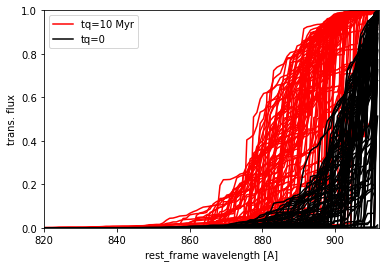

In [68]:
AA_tau1_list_qso_t0=[]
AA_tau1_list_qso_t1e7=[]


    
for tp in qso_t1e7_tau_profiles:
    plt.plot(AAout,np.exp(-tp),c='r')
    plt.ylim(0,1)
    plt.grid()
    
for tp in tau_profiles:
    plt.plot(AAout,np.exp(-tp),c='k')
    plt.ylim(0,1)
    plt.grid()
plt.plot(0,0,c='r',label="tq=10 Myr")
plt.plot(0,0,c='k',label="tq=0")
plt.xlabel("rest_frame wavelength [A]")
plt.ylabel("trans. flux")
plt.xlim(820,912)
plt.legend()

In [75]:
AAout

array([911.64852941, 910.72703482, 909.80554023, 908.88404564,
       907.96255105, 907.04105646, 906.11956187, 905.19806728,
       904.27657269, 903.3550781 , 902.43358351, 901.51208892,
       900.59059433, 899.66909974, 898.74760515, 897.82611056,
       896.90461597, 895.98312138, 895.06162679, 894.14013219,
       893.2186376 , 892.29714301, 891.37564842, 890.45415383,
       889.53265924, 888.61116465, 887.68967006, 886.76817547,
       885.84668088, 884.92518629, 884.0036917 , 883.08219711,
       882.16070252, 881.23920793, 880.31771334, 879.39621875,
       878.47472416, 877.55322957, 876.63173498, 875.71024039,
       874.7887458 , 873.86725121, 872.94575662, 872.02426203,
       871.10276744, 870.18127284, 869.25977825, 868.33828366,
       867.41678907, 866.49529448, 865.57379989, 864.6523053 ,
       863.73081071, 862.80931612, 861.88782153, 860.96632694,
       860.04483235, 859.12333776, 858.20184317, 857.28034858,
       856.35885399, 855.4373594 , 854.51586481, 853.59